In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/CarloSgaravatti/Recsys_Challenge_2023.git

Cloning into 'Recsys_Challenge_2023'...
remote: Enumerating objects: 406, done.
remote: Counting objects: 100% (235/235), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 406 (delta 170), reused 195 (delta 142), pack-reused 171
Receiving objects: 100% (406/406), 12.20 MiB | 7.16 MiB/s, done.
Resolving deltas: 100% (202/202), done.


In [2]:
! pip install PyGithub requests

  Obtaining dependency information for PyGithub from https://files.pythonhosted.org/packages/be/04/810d131be173cba445d3658a45512b2b2b3d0960d52c4a300d6ec5e00f52/PyGithub-2.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 15.1 MB/s eta 0:00:00


In [3]:
! cd /kaggle/working/Recsys_Challenge_2023 && python run_compile_all_cython.py

run_compile_all_cython: Found 10 Cython files in 4 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/10]: MatrixFactorizationImpressions_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from MatrixFactorizationImpressions_Cython_Epoch.c:1109:
/opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
MatrixFactorizationImpressions_Cython_Epoch.c: In functio

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import random
import tqdm
import gc
import time
import os
import shutil
import optuna
import scipy.sparse as sps

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hyperparameters-tuning/best_params_knn_item.json
/kaggle/input/hyperparameters-tuning/__results__.html
/kaggle/input/hyperparameters-tuning/tuning.db
/kaggle/input/hyperparameters-tuning/__notebook__.ipynb
/kaggle/input/hyperparameters-tuning/__output__.json
/kaggle/input/hyperparameters-tuning/custom.css
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/run_all_algorithms.py
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/cython_example_FunkSVD.py
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/LICENSE
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/.gitignore
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/rp3-tuning.ipynb
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/README.md
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/run_hyperparameter_search.py
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/cython_example_SLIM_MSE.py
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_202

# Configurations

In [5]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'Recsys_Challenge_2023':
        repo = r
        print('Repository found')

Repository found


In [6]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())

In [7]:
from os import system, getpid, walk
from psutil import Process
from colorama import Fore, Style, init
from IPython.display import display, HTML

def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    print(style + color + text + Style.RESET_ALL)
    
def GetMemUsage():   
    pid = getpid()
    py = Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return f"RAM memory GB usage = {memory_use :.4}"

PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 0.2158


In [8]:
config = {
    'tune_parameters_item_knn': True,
    'tune_parameters_user_knn': False,
    'tune_parameters_pure_svd': False,
    'tune_parameters_ials': False,
    'database_path': '/kaggle/working/tuning.db',
    'copy_prev_tuning_db': True,
    'copy_prev_best_params': False,
    'train_best_models': False,
    'copy_prev_best_models': False,
    'submit': False,
    'save_github': True
}

In [9]:
try:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/tuning_results/tuning.db', 
        config['database_path']
    )
except FileNotFoundError:
    pass # if not present optuna will create it

# Data Import

In [10]:
train_data = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv')
user_ids_test = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv')

In [11]:
train_data.head(5)

,row,col,data
0,1,7,1.0
1,1,15,1.0
2,1,16,1.0
3,1,133,1.0
4,1,161,1.0


In [12]:
user_ids_test.head(5)

,user_id
0,1
1,2
2,3
3,4
4,5


In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478730 entries, 0 to 478729
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   row     478730 non-null  int64  
 1   col     478730 non-null  int64  
 2   data    478730 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 11.0 MB


In [14]:
train_data.describe()

,row,col,data
count,478730.000000,478730.000000,478730.0
mean,6477.521302,4101.952798,1.0
std,3738.435208,5388.639634,0.0
min,1.000000,1.000000,1.0
25%,3204.000000,315.000000,1.0
50%,6493.000000,1575.000000,1.0
75%,9715.000000,5879.000000,1.0
max,13024.000000,22347.000000,1.0


In [15]:
n_users_train = train_data.row.max()
n_users_test = len(user_ids_test.user_id.unique())

print(f'Train number of users: {n_users_train}')
print(f'Test number of users: {n_users_test}')

Train number of users: 13024
Test number of users: 10882


In [16]:
number_of_items = train_data.col.max()

print(f'Number of items: {number_of_items}')

Number of items: 22347


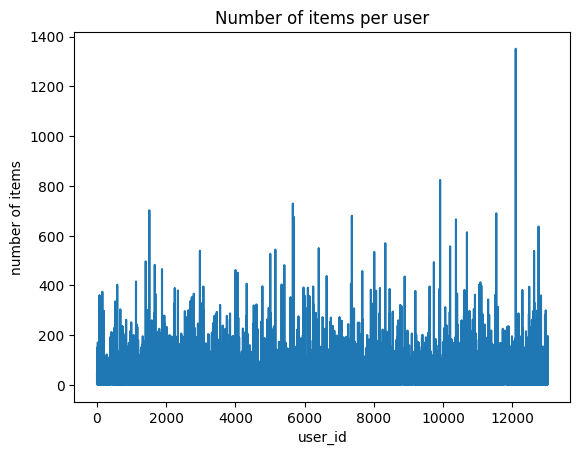

In [17]:
train_data.groupby('row').count().col.plot()
plt.xlabel('user_id')
plt.ylabel('number of items')
plt.title('Number of items per user');

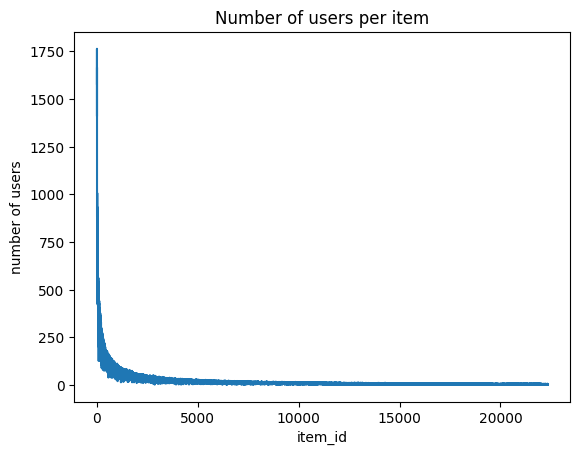

In [18]:
train_data.groupby('col').count().row.plot()
plt.xlabel('item_id')
plt.ylabel('number of users')
plt.title('Number of users per item');

In [19]:
URM_all = sps.csr_matrix((train_data.data.values,
                          ((train_data.row - 1).values, (train_data.col - 1).values)),
                        shape=(train_data.row.max(), train_data.col.max()))
URM_all

<13024x22347 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

# Cross Validation Split

In [20]:
%cd /kaggle/working/Recsys_Challenge_2023

/kaggle/working/Recsys_Challenge_2023


In [21]:
from Data_manager.IncrementalSparseMatrix import IncrementalSparseMatrix


class CrossValidationSplitter:
    def __init__(self, n_splits):
        self.n_splits = n_splits
        self.folds = []
        
    def split(self, URM):
        n_int_per_split = int(URM.nnz / self.n_splits)
        indices = np.arange(0, URM.nnz, 1)
        np.random.shuffle(indices)
        num_users, num_items = URM.shape
        
        URM_all = sps.coo_matrix(URM)
        
        for i in range(self.n_splits):
            if i == self.n_splits - 1:
                indices_valid = indices[n_int_per_split * i:]
                indices_train = indices[:n_int_per_split * i]
            else:
                indices_valid = indices[n_int_per_split * i: n_int_per_split * (i + 1)]
                indices_train_1 = indices[n_int_per_split * max(0, i - 1): n_int_per_split * i]
                indices_train_2 = indices[n_int_per_split * (i + 1):]
                indices_train = np.concatenate((indices_train_1, indices_train_2))
                
            URM_valid_builder = IncrementalSparseMatrix(
                n_rows=num_users, n_cols=num_items, auto_create_col_mapper=False, 
                auto_create_row_mapper=False
            )
            
            URM_train_builder = IncrementalSparseMatrix(
                n_rows=num_users, n_cols=num_items, auto_create_col_mapper=False, 
                auto_create_row_mapper=False
            )
            
            URM_valid_builder.add_data_lists(
                URM_all.row[indices_valid],
                URM_all.col[indices_valid],
                URM_all.data[indices_valid]
            )
            
            URM_train_builder.add_data_lists(
                URM_all.row[indices_train],
                URM_all.col[indices_train],
                URM_all.data[indices_train]
            )
            
            yield URM_train_builder.get_SparseMatrix(), URM_valid_builder.get_SparseMatrix()

# Experiments

In [22]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

In [23]:
URM_train, URM_test_complete = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_validation, URM_test = split_train_in_two_percentage_global_sample(URM_test_complete, train_percentage = 0.8)

In [24]:
# recommender = MultiThreadSLIM_SLIMElasticNetRecommender(URM_train)
# recommender.fit(l1_ratio=0.5, alpha=1, positive_only=True, topK=10)

# np.bool = bool
# np.float = float
# evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
# result_df, _ = evaluator.evaluateRecommender(recommender)
# result_df

In [25]:
# evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
# early_stopping_params = {
#     'epochs_min': 30,
#     'stop_on_validation': True,
#     'validation_every_n': 1,
#     'validation_metric': 'MAP',
#     'lower_validations_allowed': 5,
#     'evaluator_object': evaluator_validation
# }

# recommender = IALSRecommender(URM_train)
# recommender.fit(reg=1e-2, **early_stopping_params)

In [26]:
# evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])
# result_df, _ = evaluator.evaluateRecommender(recommender)
# result_df

In [27]:
# recommender = PureSVDRecommender(URM_train)
# recommender.fit(num_factors=100)

# evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
# result_df, _ = evaluator.evaluateRecommender(recommender)
# result_df

In [28]:
# recommender = ItemKNNCFRecommender(URM_train)
# recommender.fit(topK=10, shrink=100)

# evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
# result_df, _ = evaluator.evaluateRecommender(recommender)
# result_df

In [29]:
# recommender = UserKNNCFRecommender(URM_train)
# recommender.fit(topK=20, shrink=10)

# evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
# result_df, _ = evaluator.evaluateRecommender(recommender)
# result_df

# Hyperparameters tuning

In [30]:
import sqlite3

def print_all_rows(table_name, database_path):
    # Connect to the SQLite database
    connection = sqlite3.connect(database_path)

    # Create a cursor object to execute SQL queries
    cursor = connection.cursor()

    try:
        # Fetch all rows from the specified table
        cursor.execute(f"SELECT * FROM {table_name};")

        # Fetch all rows
        rows = cursor.fetchall()

        # Print the rows
        print(f"All rows from table '{table_name}':")
        for row in rows:
            print(row)

    except sqlite3.Error as e:
        print(f"Error reading data from table '{table_name}': {e}")

    finally:
        # Close the cursor and connection
        cursor.close()
        connection.close()

# Replace 'your_table_name' with the actual table name you want to print
table_name = 'studies'
print_all_rows(table_name, config['database_path'])

All rows from table 'studies':
(1, 'hyperparameters_tuning_ials')
(2, 'hyperparameters_tuning_knn_item')


Not considering adjusted cosine and pearson since they remove the mean of the interactions, but here there are all interactions equal to 1

## Item KNN Collaborative Filtering

In [31]:
from concurrent.futures import ThreadPoolExecutor

def evaluate_item_knn(URM_train, URM_valid, similarity, topK, shrink):
    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(topK=topK, shrink=shrink, similarity=similarity)

    evaluator = EvaluatorHoldout(URM_valid, cutoff_list=[10])
    result_df, _ = evaluator.evaluateRecommender(recommender)
    print(f'MAP is {result_df.loc[10, "MAP"]}')
    return result_df.loc[10, 'MAP']


def objective_item_knn(trial):
    similarity = trial.suggest_categorical('similarity', ["cosine", "asymmetric", "dice", "jaccard", "tanimoto", "tversky"])
    topK = trial.suggest_int('topK', 10, 1000)
    shrink = trial.suggest_int('shrink', 0, 500)
    
    results = [None] * 10
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = []
        for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
            futures.append(executor.submit(evaluate_item_knn, URM_train, URM_valid, similarity, topK, shrink))
        print(len(futures))
        for j, future in enumerate(futures):
            results[j] = future.result()
        
    return np.mean(results)

In [32]:
%%time

if config['tune_parameters_item_knn']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_knn_item', 
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_item_knn, n_trials=100)

[I 2023-11-22 09:29:45,734] Using an existing study with name 'hyperparameters_tuning_knn_item' instead of creating a new one.


ItemKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 180 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 597 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 235 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 767 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 925 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 568 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1151 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 864 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1441 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 09:32:35,267] Trial 100 finished with value: 0.01569747264648509 and parameters: {'similarity': 'dice', 'topK': 844, 'shrink': 39}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.02281755301304796
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 612 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 239 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 749 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 348 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 943 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 542 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1138 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 832 ( 3.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1455 (11.2%) users with no interactio

[I 2023-11-22 09:35:20,980] Trial 101 finished with value: 0.017701909253677164 and parameters: {'similarity': 'tanimoto', 'topK': 29, 'shrink': 42}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 498 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 777 ( 6.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 344 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 512 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1164 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 858 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1458 (11.2%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 09:38:08,074] Trial 102 finished with value: 0.017274538154017013 and parameters: {'similarity': 'tanimoto', 'topK': 23, 'shrink': 70}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 473 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 604 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 226 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 740 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 914 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 533 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1152 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 865 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1463 (11.2%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 09:40:58,691] Trial 103 finished with value: 0.017154323895119977 and parameters: {'similarity': 'tanimoto', 'topK': 64, 'shrink': 11}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 607 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 222 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 332 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 936 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 508 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1126 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 846 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1460 (11.2%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 09:43:58,035] Trial 104 finished with value: 0.01715791298796778 and parameters: {'similarity': 'asymmetric', 'topK': 12, 'shrink': 40}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.025119947499648826
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 161 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 503 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 589 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 220 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 767 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 352 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 534 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1168 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 884 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1409 (10.8%) users with no interacti

[I 2023-11-22 09:46:44,091] Trial 105 finished with value: 0.017220990864042163 and parameters: {'similarity': 'tanimoto', 'topK': 65, 'shrink': 48}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.02469102262411534
ItemKNNCFRecommender: URM Detected 477 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 593 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 232 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 358 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 922 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 531 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1162 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 866 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1417 (10.9%) users with no interactio

[I 2023-11-22 09:49:37,301] Trial 106 finished with value: 0.01761655814841005 and parameters: {'similarity': 'tanimoto', 'topK': 34, 'shrink': 32}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 738 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 361 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 927 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 558 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1154 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 913 ( 4.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1445 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 09:52:20,879] Trial 107 finished with value: 0.017477693108311435 and parameters: {'similarity': 'tanimoto', 'topK': 11, 'shrink': 58}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 755 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 362 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 896 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 565 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1157 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 869 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1413 (10.8%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 09:55:11,550] Trial 108 finished with value: 0.017086541867311407 and parameters: {'similarity': 'tanimoto', 'topK': 34, 'shrink': 90}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.023336777478286927
ItemKNNCFRecommender: URM Detected 510 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 193 ( 0.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 628 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 773 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 383 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 934 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 556 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1155 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 930 ( 4.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1473 (11.3%) users with no interacti

[I 2023-11-22 09:57:58,566] Trial 109 finished with value: 0.01738629035190658 and parameters: {'similarity': 'tanimoto', 'topK': 71, 'shrink': 36}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.02456028627836378
MAP is 0.0249300415444512
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 475 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 593 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 742 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 347 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 543 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1112 ( 8.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 861 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1449 (11.1%

[I 2023-11-22 10:00:52,836] Trial 110 finished with value: 0.015735196594849808 and parameters: {'similarity': 'tanimoto', 'topK': 704, 'shrink': 70}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.02306034238897901
ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 464 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 731 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 558 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1149 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 865 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1437 (11.0%) users with no interactio

[I 2023-11-22 10:03:46,820] Trial 111 finished with value: 0.017627466916154154 and parameters: {'similarity': 'tanimoto', 'topK': 13, 'shrink': 58}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.02516525265050752
ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 589 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 725 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 379 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 543 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1097 ( 8.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 904 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1405 (10.8%) users with no interactio

[I 2023-11-22 10:06:38,819] Trial 112 finished with value: 0.017624005252561387 and parameters: {'similarity': 'tanimoto', 'topK': 28, 'shrink': 27}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.025894400033903878
ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 600 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 226 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 744 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 352 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 911 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 569 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1116 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 892 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1454 (11.2%) users with no interacti

[I 2023-11-22 10:09:47,338] Trial 113 finished with value: 0.017319662614537223 and parameters: {'similarity': 'tanimoto', 'topK': 56, 'shrink': 27}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 618 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 734 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 344 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 547 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1167 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1399 (10.7%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 10:12:49,506] Trial 114 finished with value: 0.017433856936686525 and parameters: {'similarity': 'tanimoto', 'topK': 11, 'shrink': 9}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.026378924260021835
ItemKNNCFRecommender: URM Detected 472 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 185 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 157 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 577 ( 4.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 266 ( 1.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 714 ( 5.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 344 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 561 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1100 ( 8.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 853 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1370 (10.5%) users with no interacti

[I 2023-11-22 10:16:00,090] Trial 115 finished with value: 0.017110572530783928 and parameters: {'similarity': 'tanimoto', 'topK': 81, 'shrink': 49}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.023903462447544016
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 504 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 581 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 759 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 348 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 918 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 543 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1136 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 883 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1431 (11.0%) users with no interacti

[I 2023-11-22 10:19:02,424] Trial 116 finished with value: 0.01680953913844375 and parameters: {'similarity': 'cosine', 'topK': 32, 'shrink': 59}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 596 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 246 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 750 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 363 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 907 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 544 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1142 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 895 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1431 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 10:21:46,970] Trial 117 finished with value: 0.015496655130301486 and parameters: {'similarity': 'dice', 'topK': 119, 'shrink': 274}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.02099242268935393
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 613 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 739 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 366 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 896 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 580 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1147 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 930 ( 4.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1444 (11.1%) users with no interactio

[I 2023-11-22 10:24:44,800] Trial 118 finished with value: 0.01684881331080568 and parameters: {'similarity': 'asymmetric', 'topK': 59, 'shrink': 25}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.021470661900016362
MAP is 0.025051934468878014
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 499 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 604 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 244 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 743 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 359 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 914 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 563 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1120 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 884 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1448 (11

[I 2023-11-22 10:27:32,845] Trial 119 finished with value: 0.017429357541214066 and parameters: {'similarity': 'tanimoto', 'topK': 39, 'shrink': 45}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 756 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 339 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 949 ( 7.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 517 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1141 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 864 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1470 (11.3%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 10:30:23,957] Trial 120 finished with value: 0.016230420550481715 and parameters: {'similarity': 'tanimoto', 'topK': 71, 'shrink': 165}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.022656593609912765
ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 183 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 245 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 742 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 362 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 933 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 573 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1152 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 860 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1461 (11.2%) users with no interacti

[I 2023-11-22 10:33:31,688] Trial 121 finished with value: 0.017783023977510207 and parameters: {'similarity': 'tanimoto', 'topK': 10, 'shrink': 36}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 484 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 575 ( 4.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 256 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 730 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 349 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 885 ( 6.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 548 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1086 ( 8.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 892 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1422 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 10:36:25,020] Trial 122 finished with value: 0.01704568276129947 and parameters: {'similarity': 'tanimoto', 'topK': 12, 'shrink': 6}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.02567298329943921
ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 228 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 737 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 364 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 912 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 521 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1129 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 862 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1438 (11.0%) users with no interactio

[I 2023-11-22 10:39:18,645] Trial 123 finished with value: 0.01752857407977746 and parameters: {'similarity': 'tanimoto', 'topK': 34, 'shrink': 26}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.02516907850176699
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 622 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 246 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 750 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 342 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 933 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 560 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1162 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 847 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1409 (10.8%) users with no interactio

[I 2023-11-22 10:42:05,226] Trial 124 finished with value: 0.01742715417286827 and parameters: {'similarity': 'tanimoto', 'topK': 55, 'shrink': 35}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.024969358773718645
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 599 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 253 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 729 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 893 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 560 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1128 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 850 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1441 (11.1%) users with no interacti

[I 2023-11-22 10:45:17,342] Trial 125 finished with value: 0.017477621827504675 and parameters: {'similarity': 'tanimoto', 'topK': 30, 'shrink': 52}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.024972389214083526
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 613 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 233 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 747 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 935 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 507 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1156 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 848 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1426 (10.9%) users with no interacti

[I 2023-11-22 10:48:35,274] Trial 126 finished with value: 0.015340992824878006 and parameters: {'similarity': 'tanimoto', 'topK': 86, 'shrink': 395}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 611 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 743 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 354 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 908 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 543 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1131 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 860 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1436 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 10:51:42,869] Trial 127 finished with value: 0.017082185162611133 and parameters: {'similarity': 'tanimoto', 'topK': 56, 'shrink': 69}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.0242781260330542
ItemKNNCFRecommender: URM Detected 481 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 724 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 367 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 912 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 560 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1112 ( 8.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 858 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1431 (11.0%) users with no interaction

[I 2023-11-22 10:54:36,123] Trial 128 finished with value: 0.016127203981615247 and parameters: {'similarity': 'tanimoto', 'topK': 13, 'shrink': 232}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.02237321426376839
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 504 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 759 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 340 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 926 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 527 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1130 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 849 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1426 (10.9%) users with no interactio

[I 2023-11-22 10:57:25,281] Trial 129 finished with value: 0.017068654969640433 and parameters: {'similarity': 'tanimoto', 'topK': 110, 'shrink': 21}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 603 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 235 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 728 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 328 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 889 ( 6.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 521 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1136 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 879 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1431 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 11:00:09,143] Trial 130 finished with value: 0.01701967781745169 and parameters: {'similarity': 'tanimoto', 'topK': 47, 'shrink': 81}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 589 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 252 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 712 ( 5.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 350 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 887 ( 6.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 544 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1108 ( 8.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 888 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1379 (10.6%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 11:03:21,983] Trial 131 finished with value: 0.01764853072330673 and parameters: {'similarity': 'tanimoto', 'topK': 28, 'shrink': 27}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.02570235144699688
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 161 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 472 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 621 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 732 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 347 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 931 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 554 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1131 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 846 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1469 (11.3%) users with no interactio

[I 2023-11-22 11:06:21,066] Trial 132 finished with value: 0.017565925365457535 and parameters: {'similarity': 'tanimoto', 'topK': 27, 'shrink': 34}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 506 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 181 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 617 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 253 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 772 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 339 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 925 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 541 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1148 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 848 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1440 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 11:09:20,002] Trial 133 finished with value: 0.017104932594111256 and parameters: {'similarity': 'tanimoto', 'topK': 81, 'shrink': 14}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.02534697538567939
ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 603 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 752 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 346 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 544 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1155 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 851 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1434 (11.0%) users with no interactio

[I 2023-11-22 11:12:22,872] Trial 134 finished with value: 0.01750947358281164 and parameters: {'similarity': 'tanimoto', 'topK': 30, 'shrink': 44}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.024782862982663526
ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 584 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 235 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 774 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 360 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 929 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 525 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1143 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 845 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1456 (11.2%) users with no interacti

[I 2023-11-22 11:15:15,927] Trial 135 finished with value: 0.015787187400078662 and parameters: {'similarity': 'tanimoto', 'topK': 10, 'shrink': 1}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.026093526333975044
ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 612 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 346 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 921 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 570 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1164 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 855 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1475 (11.3%) users with no interacti

[I 2023-11-22 11:18:13,641] Trial 136 finished with value: 0.01721026878773037 and parameters: {'similarity': 'tanimoto', 'topK': 52, 'shrink': 58}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.025265193135553227
ItemKNNCFRecommender: URM Detected 472 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 507 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 587 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 234 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 741 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 328 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 913 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 496 ( 2.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1122 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 833 ( 3.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1424 (10.9%) users with no interacti

[I 2023-11-22 11:21:00,397] Trial 137 finished with value: 0.01670481433667794 and parameters: {'similarity': 'tanimoto', 'topK': 300, 'shrink': 21}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 249 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 714 ( 5.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 342 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 900 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 546 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1130 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1425 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 11:23:43,903] Trial 138 finished with value: 0.017350857809882658 and parameters: {'similarity': 'tversky', 'topK': 70, 'shrink': 31}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.024732511592602546
ItemKNNCFRecommender: URM Detected 481 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 180 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 192 ( 0.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 753 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 389 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 920 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 555 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1195 ( 9.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 896 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1443 (11.1%) users with no interacti

[I 2023-11-22 11:26:31,601] Trial 139 finished with value: 0.01688965648495454 and parameters: {'similarity': 'cosine', 'topK': 36, 'shrink': 44}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 184 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 596 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 261 ( 1.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 741 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 375 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 904 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 550 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1113 ( 8.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 889 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1456 (11.2%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 11:29:20,495] Trial 140 finished with value: 0.016688175791869885 and parameters: {'similarity': 'dice', 'topK': 103, 'shrink': 12}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.02487604636753147
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 588 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 757 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 325 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 899 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 537 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1149 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 837 ( 3.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1446 (11.1%) users with no interactio

[I 2023-11-22 11:32:03,950] Trial 141 finished with value: 0.01750184330681791 and parameters: {'similarity': 'tanimoto', 'topK': 33, 'shrink': 35}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 471 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 597 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 249 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 742 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 343 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 927 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 537 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1154 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 899 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1461 (11.2%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 11:34:53,182] Trial 142 finished with value: 0.017575437258071973 and parameters: {'similarity': 'tanimoto', 'topK': 31, 'shrink': 34}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.017102143488974524
MAP is 0.025057238416118757
ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 477 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 619 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 258 ( 1.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 733 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 935 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 546 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1136 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 883 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1429 (11

[I 2023-11-22 11:37:42,110] Trial 143 finished with value: 0.017612004153531164 and parameters: {'similarity': 'tanimoto', 'topK': 11, 'shrink': 51}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 471 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 600 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 724 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 377 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 911 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 536 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1153 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 943 ( 4.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1424 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 11:40:48,072] Trial 144 finished with value: 0.017119201713676674 and parameters: {'similarity': 'tanimoto', 'topK': 54, 'shrink': 54}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 618 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 234 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 734 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 380 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 923 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 547 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1137 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 895 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1430 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 11:43:43,758] Trial 145 finished with value: 0.017401946418151557 and parameters: {'similarity': 'tanimoto', 'topK': 10, 'shrink': 62}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.025344548575931516
MAP is 0.024880996462867226
ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 617 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 233 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 729 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 923 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 517 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1115 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 895 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1421 (10

[I 2023-11-22 11:46:31,786] Trial 146 finished with value: 0.017145896509079012 and parameters: {'similarity': 'tanimoto', 'topK': 75, 'shrink': 46}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 648 ( 5.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 244 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 766 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 362 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 949 ( 7.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 556 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1183 ( 9.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 871 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1471 (11.3%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 11:49:29,284] Trial 147 finished with value: 0.01687465176195229 and parameters: {'similarity': 'asymmetric', 'topK': 50, 'shrink': 22}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.02091208919323566
MAP is 0.02473198968555869
ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 186 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 624 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 233 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 737 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 360 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 554 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1139 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 892 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1421 (10.9

[I 2023-11-22 11:52:30,738] Trial 148 finished with value: 0.017446567457156073 and parameters: {'similarity': 'tanimoto', 'topK': 10, 'shrink': 67}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.0251555280331539
MAP is 0.018867664875684743
ItemKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 621 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 757 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 378 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 531 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1163 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 900 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1455 (11.2

[I 2023-11-22 11:55:31,149] Trial 149 finished with value: 0.017169685224551486 and parameters: {'similarity': 'tanimoto', 'topK': 86, 'shrink': 41}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.024140819497962394
ItemKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 498 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 586 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 740 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 346 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 513 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1137 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 876 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1410 (10.8%) users with no interacti

[I 2023-11-22 11:58:25,803] Trial 150 finished with value: 0.016858785766349645 and parameters: {'similarity': 'tanimoto', 'topK': 45, 'shrink': 103}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.023584795275368997
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 719 ( 5.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 350 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 912 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 536 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1124 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 863 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1391 (10.7%) users with no interacti

[I 2023-11-22 12:01:24,078] Trial 151 finished with value: 0.01761504667112202 and parameters: {'similarity': 'tanimoto', 'topK': 28, 'shrink': 33}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 758 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 358 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 927 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 529 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1165 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1450 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 12:04:37,959] Trial 152 finished with value: 0.017567551450603347 and parameters: {'similarity': 'tanimoto', 'topK': 28, 'shrink': 29}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 475 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 187 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 607 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 239 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 752 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 367 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 915 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 570 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1145 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 905 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1446 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 12:07:53,575] Trial 153 finished with value: 0.017140504649252618 and parameters: {'similarity': 'tanimoto', 'topK': 54, 'shrink': 13}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.02558394125110892
ItemKNNCFRecommender: URM Detected 501 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 231 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 758 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 353 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 922 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 549 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1161 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 848 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1438 (11.0%) users with no interactio

[I 2023-11-22 12:10:40,947] Trial 154 finished with value: 0.01761943331724338 and parameters: {'similarity': 'tanimoto', 'topK': 12, 'shrink': 50}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 727 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 359 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 928 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 519 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1135 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 865 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1463 (11.2%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 12:13:51,717] Trial 155 finished with value: 0.01734530676150734 and parameters: {'similarity': 'jaccard', 'topK': 72, 'shrink': 23}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 505 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 469 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 635 ( 4.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 245 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 939 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 548 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1171 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 908 ( 4.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1445 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 12:16:57,596] Trial 156 finished with value: 0.017593060327237175 and parameters: {'similarity': 'tanimoto', 'topK': 31, 'shrink': 41}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.024762366544755977
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 592 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 250 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 736 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 929 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 558 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1160 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 891 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1427 (11.0%) users with no interacti

[I 2023-11-22 12:19:55,662] Trial 157 finished with value: 0.01754607865109028 and parameters: {'similarity': 'tanimoto', 'topK': 10, 'shrink': 58}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.025267800127713905
ItemKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 182 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 633 ( 4.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 258 ( 1.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 751 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 349 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 926 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 533 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1164 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 859 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1449 (11.1%) users with no interacti

[I 2023-11-22 12:22:53,528] Trial 158 finished with value: 0.016953472460869763 and parameters: {'similarity': 'tanimoto', 'topK': 61, 'shrink': 75}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.019295176537835752
MAP is 0.023282990404328616
ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 752 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 916 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 551 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1139 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 851 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1407 (10

[I 2023-11-22 12:25:49,442] Trial 159 finished with value: 0.01743267421334588 and parameters: {'similarity': 'tanimoto', 'topK': 41, 'shrink': 30}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.0252612335540978
ItemKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 628 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 759 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 328 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 929 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 545 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1170 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1453 (11.2%) users with no interaction

[I 2023-11-22 12:28:55,724] Trial 160 finished with value: 0.014652069922857308 and parameters: {'similarity': 'tversky', 'topK': 97, 'shrink': 0}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.02431119205449841
ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 599 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 746 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 347 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 558 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1161 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 882 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1428 (11.0%) users with no interactio

[I 2023-11-22 12:31:55,064] Trial 161 finished with value: 0.01748753658832715 and parameters: {'similarity': 'tanimoto', 'topK': 26, 'shrink': 47}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.0248937056066911
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 604 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 244 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 730 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 369 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 926 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 577 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1154 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 879 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1418 (10.9%) users with no interaction

[I 2023-11-22 12:34:48,916] Trial 162 finished with value: 0.017493409631208406 and parameters: {'similarity': 'tanimoto', 'topK': 10, 'shrink': 53}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.024457618674637804
MAP is 0.019238532511259746
ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 612 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 759 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 339 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 899 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 561 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1153 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 851 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1426 (10

[I 2023-11-22 12:37:50,463] Trial 163 finished with value: 0.016450228425575017 and parameters: {'similarity': 'tanimoto', 'topK': 357, 'shrink': 17}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 600 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 258 ( 1.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 779 ( 6.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 355 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 914 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 562 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1175 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 896 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1462 (11.2%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 12:40:42,390] Trial 164 finished with value: 0.017386861250736088 and parameters: {'similarity': 'tanimoto', 'topK': 43, 'shrink': 33}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.021772161999636764
MAP is 0.024866678780792274
MAP is 0.024479946160875166
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 475 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 727 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 357 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 924 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 561 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1121 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 854 ( 3.8%) items with no interactions.
ItemKNNCFRecomm

[I 2023-11-22 12:43:39,150] Trial 165 finished with value: 0.017653729144779973 and parameters: {'similarity': 'jaccard', 'topK': 10, 'shrink': 42}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.02494383441443238
ItemKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 631 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 227 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 735 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 922 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 532 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1153 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 864 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1459 (11.2%) users with no interactio

[I 2023-11-22 12:46:28,533] Trial 166 finished with value: 0.017289297080034603 and parameters: {'similarity': 'jaccard', 'topK': 60, 'shrink': 41}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 613 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 742 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 925 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 555 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1164 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 887 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1419 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 12:49:20,448] Trial 167 finished with value: 0.015723488111186037 and parameters: {'similarity': 'jaccard', 'topK': 27, 'shrink': 340}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 741 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 960 ( 7.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 553 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1130 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 821 ( 3.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1438 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 12:52:10,182] Trial 168 finished with value: 0.017465260460751718 and parameters: {'similarity': 'jaccard', 'topK': 73, 'shrink': 24}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.02480208694920427
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 620 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 738 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 357 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 534 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1169 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 860 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1436 (11.0%) users with no interactio

[I 2023-11-22 12:54:58,099] Trial 169 finished with value: 0.01729008591387922 and parameters: {'similarity': 'jaccard', 'topK': 39, 'shrink': 12}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.02542153206819731
MAP is 0.02476693500503022
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 577 ( 4.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 248 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 774 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 345 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 545 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1170 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 860 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1446 (11.1

[I 2023-11-22 12:58:00,128] Trial 170 finished with value: 0.015737650306797846 and parameters: {'similarity': 'jaccard', 'topK': 988, 'shrink': 60}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.0205524615727333
ItemKNNCFRecommender: URM Detected 502 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 484 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 616 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 769 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 940 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 542 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1168 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 849 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1469 (11.3%) users with no interaction

[I 2023-11-22 13:00:50,992] Trial 171 finished with value: 0.01773280234242313 and parameters: {'similarity': 'tanimoto', 'topK': 11, 'shrink': 50}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.025145493821277686
ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 188 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 610 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 749 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 375 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 890 ( 6.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 574 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1179 ( 9.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 857 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1423 (10.9%) users with no interacti

[I 2023-11-22 13:03:39,511] Trial 172 finished with value: 0.017576638022135407 and parameters: {'similarity': 'tanimoto', 'topK': 25, 'shrink': 40}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.02440526199425157
ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 583 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 737 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 357 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 902 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 548 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1109 ( 8.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 858 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1420 (10.9%) users with no interactio

[I 2023-11-22 13:06:30,736] Trial 173 finished with value: 0.017427720881990055 and parameters: {'similarity': 'tanimoto', 'topK': 47, 'shrink': 32}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.025768825551735573
MAP is 0.025154567685435315
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 506 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 227 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 363 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 921 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 545 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1129 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 887 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1473 (11

[I 2023-11-22 13:09:29,504] Trial 174 finished with value: 0.01768329187346425 and parameters: {'similarity': 'tanimoto', 'topK': 10, 'shrink': 50}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 181 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 602 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 231 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 740 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 353 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 929 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 533 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1119 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 887 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1409 (10.8%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 13:12:34,581] Trial 175 finished with value: 0.016718887832551675 and parameters: {'similarity': 'cosine', 'topK': 12, 'shrink': 70}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 462 ( 3.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 579 ( 4.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 258 ( 1.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 733 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 346 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 901 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 542 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1142 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 878 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1423 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 13:15:38,482] Trial 176 finished with value: 0.017678274948447807 and parameters: {'similarity': 'dice', 'topK': 11, 'shrink': 49}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.025097229430874703
ItemKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 604 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 225 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 741 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 920 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 541 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1142 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 842 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1414 (10.9%) users with no interacti

[I 2023-11-22 13:18:47,474] Trial 177 finished with value: 0.015826565828877173 and parameters: {'similarity': 'dice', 'topK': 420, 'shrink': 50}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.02227105956254134
MAP is 0.022369658962425352
MAP is 0.020843594924985095
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 506 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 610 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 251 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 768 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 367 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 931 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 546 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1161 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 829 ( 3.7%) items with no interactions.
ItemKNNCFRecomme

[I 2023-11-22 13:21:49,357] Trial 178 finished with value: 0.01664516490440985 and parameters: {'similarity': 'dice', 'topK': 59, 'shrink': 82}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.02300641575580419
ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 481 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 185 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 618 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 739 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 357 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 907 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 561 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1134 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 846 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1405 (10.8%) users with no interactio

[I 2023-11-22 13:24:50,884] Trial 179 finished with value: 0.017316806868283654 and parameters: {'similarity': 'dice', 'topK': 10, 'shrink': 63}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 477 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 234 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 753 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 378 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 540 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1147 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 877 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1480 (11.4%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 13:27:47,449] Trial 180 finished with value: 0.01704944298664289 and parameters: {'similarity': 'dice', 'topK': 44, 'shrink': 51}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.024590446743441803
ItemKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 161 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 766 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 359 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 914 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 580 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1162 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 879 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1429 (11.0%) users with no interacti

[I 2023-11-22 13:30:39,728] Trial 181 finished with value: 0.01778172376201979 and parameters: {'similarity': 'tanimoto', 'topK': 10, 'shrink': 42}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.025041184277157864
ItemKNNCFRecommender: URM Detected 505 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 617 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 783 ( 6.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 344 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 942 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 544 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1185 ( 9.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 848 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1450 (11.1%) users with no interacti

[I 2023-11-22 13:33:29,035] Trial 182 finished with value: 0.017691769887274472 and parameters: {'similarity': 'tanimoto', 'topK': 11, 'shrink': 43}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.025042956228850097
ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 469 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 638 ( 4.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 252 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 731 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 340 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 926 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 545 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1157 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 840 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1457 (11.2%) users with no interacti

[I 2023-11-22 13:36:19,838] Trial 183 finished with value: 0.017464255933547307 and parameters: {'similarity': 'jaccard', 'topK': 32, 'shrink': 42}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 626 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 755 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 358 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 941 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 522 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1147 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 918 ( 4.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1444 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 13:39:21,149] Trial 184 finished with value: 0.017233275061029125 and parameters: {'similarity': 'asymmetric', 'topK': 28, 'shrink': 22}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 157 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 606 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 227 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 728 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 920 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 546 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1130 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 842 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1426 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 13:42:29,317] Trial 185 finished with value: 0.016973138642471373 and parameters: {'similarity': 'tanimoto', 'topK': 61, 'shrink': 59}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 635 ( 4.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 249 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 739 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 374 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 956 ( 7.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 548 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1167 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 895 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1483 (11.4%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 13:45:21,485] Trial 186 finished with value: 0.01772022346876036 and parameters: {'similarity': 'tanimoto', 'topK': 11, 'shrink': 40}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.022639471167990626
ItemKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 245 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 771 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 350 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 916 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 526 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1146 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 876 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1451 (11.1%) users with no interacti

[I 2023-11-22 13:48:14,307] Trial 187 finished with value: 0.017823665872409696 and parameters: {'similarity': 'dice', 'topK': 10, 'shrink': 43}. Best is trial 187 with value: 0.017823665872409696.


ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 505 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 606 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 760 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 948 ( 7.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 592 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1160 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 896 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1471 (11.3%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 13:51:04,338] Trial 188 finished with value: 0.017362764684310257 and parameters: {'similarity': 'dice', 'topK': 11, 'shrink': 70}. Best is trial 187 with value: 0.017823665872409696.


MAP is 0.02550370188689865
ItemKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 606 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 772 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 361 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 936 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 533 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1132 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 883 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1437 (11.0%) users with no interactio

[I 2023-11-22 13:53:54,874] Trial 189 finished with value: 0.017654031398508484 and parameters: {'similarity': 'dice', 'topK': 10, 'shrink': 43}. Best is trial 187 with value: 0.017823665872409696.


ItemKNNCFRecommender: URM Detected 499 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 252 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 784 ( 6.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 329 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 923 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 551 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1160 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 853 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1487 (11.4%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 13:56:50,098] Trial 190 finished with value: 0.01569932614465323 and parameters: {'similarity': 'dice', 'topK': 893, 'shrink': 42}. Best is trial 187 with value: 0.017823665872409696.


ItemKNNCFRecommender: URM Detected 498 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 180 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 622 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 249 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 726 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 371 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 932 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 555 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1124 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1431 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 13:59:35,417] Trial 191 finished with value: 0.01766231788942959 and parameters: {'similarity': 'dice', 'topK': 10, 'shrink': 53}. Best is trial 187 with value: 0.017823665872409696.


MAP is 0.02530371611593249
ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 502 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 180 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 588 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 728 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 920 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 541 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1110 ( 8.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 897 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1417 (10.9%) users with no interactio

[I 2023-11-22 14:02:17,958] Trial 192 finished with value: 0.017475899180435555 and parameters: {'similarity': 'dice', 'topK': 10, 'shrink': 51}. Best is trial 187 with value: 0.017823665872409696.


ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 590 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 768 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 363 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 555 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1120 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 894 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1447 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 14:05:02,703] Trial 193 finished with value: 0.01597118284775287 and parameters: {'similarity': 'dice', 'topK': 46, 'shrink': 192}. Best is trial 187 with value: 0.017823665872409696.


MAP is 0.021337241831106756
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 471 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 717 ( 5.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 362 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 933 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 554 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1129 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 913 ( 4.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1414 (10.9%) users with no interacti

[I 2023-11-22 14:07:50,513] Trial 194 finished with value: 0.017021305404467453 and parameters: {'similarity': 'dice', 'topK': 42, 'shrink': 41}. Best is trial 187 with value: 0.017823665872409696.


MAP is 0.021069312578199793
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 471 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 233 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 360 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 902 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 560 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1154 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 859 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1409 (10.8%) users with no interacti

[I 2023-11-22 14:10:33,857] Trial 195 finished with value: 0.017738997425162654 and parameters: {'similarity': 'dice', 'topK': 10, 'shrink': 23}. Best is trial 187 with value: 0.017823665872409696.


MAP is 0.02598418131376063
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 740 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 363 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 945 ( 7.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 532 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1115 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 872 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1446 (11.1%) users with no interactio

[I 2023-11-22 14:13:20,095] Trial 196 finished with value: 0.017251543244244907 and parameters: {'similarity': 'dice', 'topK': 29, 'shrink': 15}. Best is trial 187 with value: 0.017823665872409696.


MAP is 0.025433758487715268
ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 637 ( 4.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 754 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 956 ( 7.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 545 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1179 ( 9.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 884 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1426 (10.9%) users with no interacti

[I 2023-11-22 14:16:04,840] Trial 197 finished with value: 0.017736524920570457 and parameters: {'similarity': 'dice', 'topK': 11, 'shrink': 34}. Best is trial 187 with value: 0.017823665872409696.


ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 618 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 736 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 353 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 904 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 563 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1153 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 855 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1448 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-22 14:18:50,203] Trial 198 finished with value: 0.01722862142673358 and parameters: {'similarity': 'dice', 'topK': 53, 'shrink': 27}. Best is trial 187 with value: 0.017823665872409696.


MAP is 0.024902286841489603
ItemKNNCFRecommender: URM Detected 511 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 477 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 232 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 766 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 360 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 939 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 527 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1152 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 858 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1452 (11.1%) users with no interacti

[I 2023-11-22 14:21:36,570] Trial 199 finished with value: 0.01717980069954713 and parameters: {'similarity': 'dice', 'topK': 28, 'shrink': 62}. Best is trial 187 with value: 0.017823665872409696.


CPU times: user 5h 57min 45s, sys: 1h 31min 35s, total: 7h 29min 20s
Wall time: 4h 51min 51s


In [33]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [34]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [35]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [36]:
if config['tune_parameters_item_knn']:
    with open('/kaggle/working/best_params_knn_item.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_knn_item.json', 
            'tuning_results/best_params_knn_item.json', 
            'Item KNN tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning/best_params_knn_item.json', 
        '/kaggle/working/best_params_knn_item.json'
    )

## User KNN Collaborative Filtering

In [37]:
def objective_user_knn(trial):
    similarity = trial.suggest_categorical('similarity', ["cosine", "asymmetric", "dice", "jaccard", "tanimoto", "tversky"])
    topK = trial.suggest_int('topK', 10, 1000)
    shrink = trial.suggest_int('shrink', 0, 500)
    
    map_sum = 0
    for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
        recommender = UserKNNCFRecommender(URM_train)
        recommender.fit(topK=topK, shrink=shrink, similarity=similarity)

        evaluator = EvaluatorHoldout(URM_valid, cutoff_list=[10])
        result_df, _ = evaluator.evaluateRecommender(recommender)
        map_sum += result_df.loc[10, 'MAP']
    return map_sum / 10

In [38]:
%%time

if config['tune_parameters_user_knn']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_knn_user',
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_user_knn, n_trials=75)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.54 µs


In [39]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [40]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [41]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [42]:
if config['tune_parameters_user_knn']:
    with open('/kaggle/working/best_params_knn_user.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_knn_user.json', 
            'tuning_results/best_params_knn_user.json', 
            'User KNN tuning results (from kaggle notebook)'
        )
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning/best_params_knn_user.json', 
        '/kaggle/working/best_params_knn_user.json'
    )

## PureSVD

In [43]:
%%time

def evaluate_pure_svd(URM_train, URM_valid, num_factors):
    recommender = PureSVDRecommender(URM_train)
    recommender.fit(num_factors=num_factors)

    evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
    result_df, _ = evaluator.evaluateRecommender(recommender)
    return result_df.loc[10, 'MAP']

if config['tune_parameters_pure_svd']:
    n_factors = np.arange(5, 501, 5)
    map_results = []

    for i, factors in enumerate(n_factors):
        
        results = [None] * 10
        with ThreadPoolExecutor(max_workers=10) as executor:
            futures = []
            for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
                futures.append(executor.submit(evaluate_pure_svd, URM_train, URM_valid, factors))
            for j, future in enumerate(futures):
                results[j] = future.result()
        map_results.append(np.mean(results))
        PrintColor(f'End trial {i}, with factors = {factors}: MAP is {np.mean(results)}')

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 14.1 µs


In [44]:
# sorted_indices = np.argsort(n_factors)
if config['tune_parameters_pure_svd']:
    plt.plot(n_factors, np.array(map_results))
    plt.xlabel('Factors')
    plt.ylabel('MAP')
    plt.title('Pure SVD Recommender')
    plt.show()

In [45]:
if config['tune_parameters_pure_svd']:
    params = {'factors': int(n_factors[np.argsort(map_results)[-1]])}

    with open('/kaggle/working/pure_svd_params.json', 'w') as params_file:
        json.dump(params, params_file)
        
    trials = pd.DataFrame({'factor': n_factors, 'MAP': np.array(map_results)})
    trials.to_csv('/kaggle/working/pure_svd_trials.csv', index=False)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/pure_svd_params.json', 
            'tuning_results/pure_svd_params.json', 
            'Pure SVD tuning best params (from kaggle notebook)'
        )
        
        upload_file(
            '/kaggle/working/pure_svd_trials.csv', 
            'tuning_results/pure_svd_trials.csv',
            'Pure SVD tuning trial results (from kaggle notebook)'
        )
        
elif config['copy_prev_best_params']:
    try:
        shutil.copyfile(
            '/kaggle/input/hyperparameters-tuning/pure_svd_params.json', 
            '/kaggle/working/pure_svd_params.json'
        )
    except FileNotFoundError:
        pass # not already tuned

# Alternating Least Squares

In [46]:
def objective_ials(trial):
    reg = trial.suggest_float('reg', 1e-5, 1, log=True)
    alpha = trial.suggest_float('alpha', 0.1, 1)
    num_factors = trial.suggest_int('num_factors', 10, 200)
    
    map_sum = 0
    for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
        evaluator_validation = EvaluatorHoldout(URM_valid, cutoff_list=[10])
        early_stopping_params = {
            'epochs_min': 1,
            'stop_on_validation': True,
            'validation_every_n': 1,
            'validation_metric': 'MAP',
            'lower_validations_allowed': 3,
            'evaluator_object': evaluator_validation
        }

        recommender = IALSRecommender(URM_train)
        recommender.fit(reg=reg, alpha=alpha, num_factors=num_factors, **early_stopping_params)

        evaluator = EvaluatorHoldout(URM_valid, cutoff_list=[10])
        result_df, _ = evaluator.evaluateRecommender(recommender)
        map_sum += result_df.loc[10, 'MAP']
    return map_sum / 10

In [47]:
%%time

if config['tune_parameters_ials']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_ials',
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_ials, n_trials=5)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.78 µs


In [48]:
if config['tune_parameters_ials']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [49]:
if config['tune_parameters_ials']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [50]:
if config['tune_parameters_ials']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [51]:
if config['tune_parameters_ials']:
    with open('/kaggle/working/best_params_ials.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_ials.json', 
            'tuning_results/best_params_ials.json', 
            'IALS tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning/best_params_ials.json', 
        '/kaggle/working/best_params_ials.json'
    )

In [52]:
if config['save_github'] and (config['tune_parameters_user_knn'] or config['tune_parameters_item_knn'] or config['tune_parameters_ials']):
    upload_file(
        config['database_path'], 
        'tuning_results/tuning.db', 
        'Tuning db updated results (from kaggle notebook)'
    )

# Training best model

In [53]:
# with open('/kaggle/working/best_params_knn_item.json', 'r') as params_file:
#     params_knn = json.load(params_file)

# recommender = ItemKNNCFRecommender(URM_all)
# recommender.fit(topK=params_knn['topK'], shrink=params_knn['shrink'], similarity=params_knn['similarity'])

# Submission

In [54]:
# user_ids_test.info()

In [55]:
# user_ids_test.head(5)

In [56]:
# user_ids_test['user_id'].unique()

In [57]:
# # user_id and item_id start from 1
# recommendations = recommender.recommend(user_ids_test['user_id'].unique() - 1, cutoff=10)
# recommendations = [' '.join([str(item + 1) for item in r]).strip() for r in recommendations]

# submission_df = pd.DataFrame({'user_id': user_ids_test['user_id'].unique(), 'item_list': recommendations})
# submission_df.head()

In [58]:
# submission_df.to_csv('/kaggle/working/submission.csv', index=False)